C:\Users\hp\AppData\Local\Temp\ipykernel_15700\956188970.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers=symbol, period=period, interval=interval, progress=False)
C:\Users\hp\AppData\Local\Temp\ipykernel_15700\956188970.py:44: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_return = float(returns.mean()) * 252
C:\Users\hp\AppData\Local\Temp\ipykernel_15700\956188970.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volatility = float(returns.std()) * np.sqrt(252)


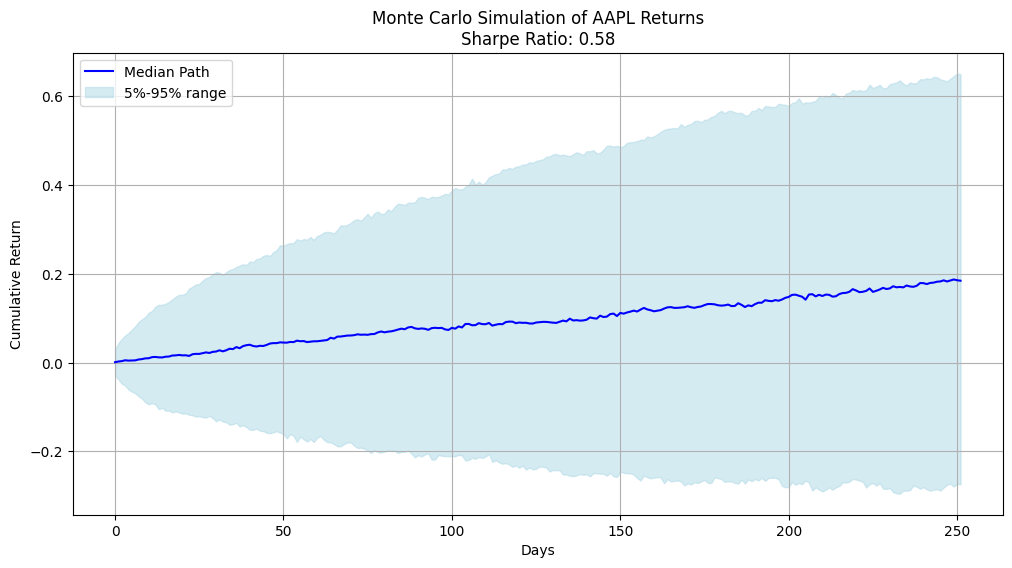

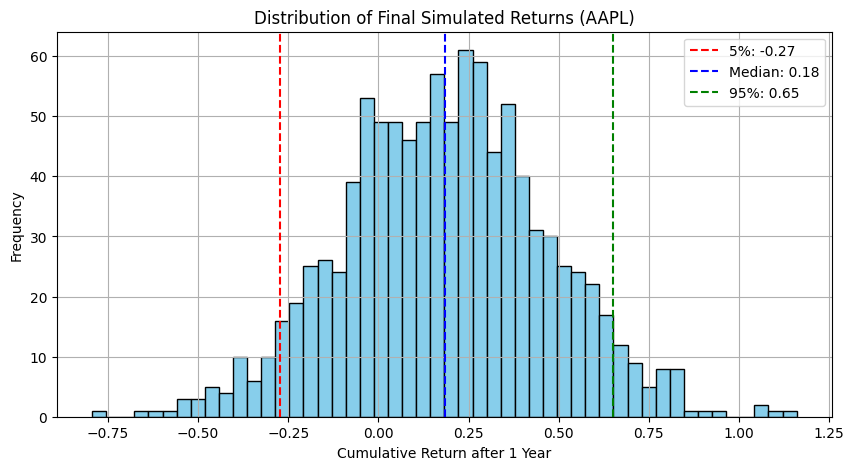

In [12]:
import logging
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# Logging Configuration
# ------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.StreamHandler()]
)

# Config
STOCK_SYMBOL = "AAPL"

# ------------------------------
# Data Fetching
# ------------------------------
def fetch_historical_data(symbol="AAPL", period="5y", interval="1d"):
    """
    Fetch historical stock data using yfinance.
    """
    logging.info(f"Fetching historical data for {symbol}...")
    try:
        data = yf.download(tickers=symbol, period=period, interval=interval, progress=False)
        return data
    except Exception as e:
        logging.error(f"Error fetching data: {e}")
        return None

# ------------------------------
# Stock Analytics (Single Stock)
# ------------------------------
def stock_analysis(data, symbol="AAPL"):
    logging.info(f"Running analytics for {symbol}...")

    # Returns
    returns = data['Close'].pct_change().dropna()

    # Ensure scalar floats
    mean_return = float(returns.mean()) * 252
    volatility = float(returns.std()) * np.sqrt(252)

    # Sharpe Ratio
    rf = 0.03
    sharpe_ratio = (mean_return - rf) / volatility if volatility > 0 else np.nan

    logging.info(f"{symbol} Annual Return: {mean_return:.4f}")
    logging.info(f"{symbol} Volatility: {volatility:.4f}")
    logging.info(f"{symbol} Sharpe Ratio: {sharpe_ratio:.4f}")

    # Value at Risk (95%)
    var_95 = np.percentile(returns, 5)
    logging.info(f"{symbol} 95% VaR: {var_95:.4f}")

    # ---- Monte Carlo Simulation ----
    num_days = 252
    num_sims = 1000
    simulations = np.random.normal(mean_return / 252, volatility / np.sqrt(252), (num_days, num_sims))
    sim_df = pd.DataFrame(simulations).cumsum()

    # Compute percentiles of paths
    p5 = sim_df.quantile(0.05, axis=1)
    p50 = sim_df.quantile(0.5, axis=1)
    p95 = sim_df.quantile(0.95, axis=1)

    # Plot fan chart of simulated returns
    plt.figure(figsize=(12,6))
    plt.plot(p50, label="Median Path", color="blue")
    plt.fill_between(range(num_days), p5, p95, color="lightblue", alpha=0.5, label="5%-95% range")
    plt.title(f"Monte Carlo Simulation of {symbol} Returns\nSharpe Ratio: {sharpe_ratio:.2f}")
    plt.xlabel("Days")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Final outcomes distribution
    final_returns = sim_df.iloc[-1, :]
    p5_final = np.percentile(final_returns, 5)
    p50_final = np.percentile(final_returns, 50)
    p95_final = np.percentile(final_returns, 95)

    plt.figure(figsize=(10,5))
    plt.hist(final_returns, bins=50, color="skyblue", edgecolor="black")
    plt.axvline(p5_final, color="red", linestyle="--", label=f"5%: {p5_final:.2f}")
    plt.axvline(p50_final, color="blue", linestyle="--", label=f"Median: {p50_final:.2f}")
    plt.axvline(p95_final, color="green", linestyle="--", label=f"95%: {p95_final:.2f}")
    plt.title(f"Distribution of Final Simulated Returns ({symbol})")
    plt.xlabel("Cumulative Return after 1 Year")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------------------
# Main Execution
# ------------------------------
if __name__ == "__main__":
    df = fetch_historical_data(STOCK_SYMBOL)
    if df is not None and not df.empty:
        stock_analysis(df, STOCK_SYMBOL)
